# Universidad de O'Higgins

## Escuela de Ingeniería
## COM4402: Introducción a Inteligencia Artificial

### **Tarea 2: Clasificación de Dígitos Manuscritos con Redes Neuronales**

### Estudiante: Francisco Ignacio Guzmán Ramírez

El objetivo de esta tarea es utilizar redes neuronales en un problema de clasificación de dígitos. Se utilizará el conjunto de datos Optical Recognition of Handwritten Digits Data Set. Este conjunto tiene 64 características, con 10 clases y 5620 muestras en total. La base de datos estará disponible en U-Campus.

Las redes a ser entrenadas tienen la siguiente estructura: capa de entrada de dimensionalidad 64 (correspondiente a los datos de entrada), capas ocultas (una o dos) y capa de salida con 10 neuronas y función de activación softmax. La función de loss (pérdida) es entropía cruzada. El optimizador que se
debe usar es Adam. La función softmax está implícita al usar la función de pérdida CrossEntropyLoss de PyTorch (**no se debe agregar softmax a la salida de la red**).

Se usará PyTorch para entrenar y validar la red neuronal que implementa el clasificador de dígitos. Se analizará los efectos de cambiar el tamaño de la red (número de capas ocultas y de neuronas en estas
capas) y la función de activación.

El siguiente código base debe ser usado para realizar las actividades pedidas.

## Observación: Antes de ejecutar su código, active el uso de GPU en Google Colab para acelerar el proceso de entrenamiento.

### Para esto: vaya a "Entorno de Ejecución" en el menú superior, haga click en "Cambiar tipo de entorno de ejecución", y seleccionar/verificar "GPU" en "Acelerador de Hardware"

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt

--2023-10-29 00:19:06--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640604 (626K) [text/plain]
Saving to: ‘1_digits_train.txt’

1_digits_train.txt  100%[===================>] 625.59K  --.-KB/s    in 0.04s   

2023-10-29 00:19:07 (16.3 MB/s) - ‘1_digits_train.txt’ saved [640604/640604]



In [4]:
!wget https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt

--2023-10-29 00:19:08--  https://raw.githubusercontent.com/Felipe1401/Mineria/main/dataset_digits/1_digits_test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187595 (183K) [text/plain]
Saving to: ‘1_digits_test.txt’

1_digits_test.txt   100%[===================>] 183.20K  --.-KB/s    in 0.02s   

2023-10-29 00:19:09 (8.92 MB/s) - ‘1_digits_test.txt’ saved [187595/187595]



## Subir datasets de dígitos (train)

## Leer dataset de dígitos

In [5]:
column_names = ["feat" + str(i) for i in range(64)]
column_names.append("class")

In [6]:
df_train_val = pd.read_csv('1_digits_train.txt', names = column_names)
df_train_val

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,0,0,9,11,0,0,0,0,0,7,...,0,0,0,8,12,12,15,10,0,2
4343,0,0,6,15,2,0,0,0,0,0,...,0,0,0,7,16,16,10,1,0,6
4344,0,0,15,16,16,14,0,0,0,0,...,0,0,0,14,11,0,0,0,0,7
4345,0,0,0,1,15,11,0,0,0,0,...,0,0,0,0,1,16,10,0,0,4


In [7]:
df_test = pd.read_csv('1_digits_test.txt', names = column_names)
df_test

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
0,0,0,13,12,10,12,8,0,0,2,...,0,0,0,10,16,16,8,0,0,5
1,0,0,8,16,14,4,0,0,0,5,...,0,0,0,10,16,14,12,2,0,9
2,0,0,0,7,16,0,0,0,0,0,...,0,0,0,0,9,15,1,0,0,4
3,0,0,2,14,9,2,0,0,0,0,...,0,0,0,2,14,14,2,0,0,0
4,0,1,16,16,15,3,0,0,0,0,...,0,0,0,16,6,0,0,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1267,0,0,5,13,11,2,0,0,0,2,...,0,0,0,8,13,15,10,1,0,9
1268,0,0,0,1,12,1,0,0,0,0,...,0,0,0,0,4,9,0,0,0,4
1269,0,0,3,15,0,0,0,0,0,0,...,0,0,0,4,14,16,9,0,0,6
1270,0,0,6,16,2,0,0,0,0,0,...,0,0,0,5,16,16,16,5,0,6


**Se dividen los datos de entrenamiento en validación, entrenamiento y prueba.**

In [8]:
df_train, df_val = train_test_split(df_train_val, test_size = 0.3, random_state = 10)

In [9]:
scaler = StandardScaler().fit(df_train.iloc[:,0:64])
df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
df_test.iloc[:,0:64] = scaler.transform(df_test.iloc[:,0:64])

<ipython-input-9-9f48500b620a>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.iloc[:,0:64] = scaler.transform(df_train.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_val.iloc[:,0:64] = scaler.transform(df_val.iloc[:,0:64])
<ipython-input-9-9f48500b620a>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns

In [10]:
df_train

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,...,feat55,feat56,feat57,feat58,feat59,feat60,feat61,feat62,feat63,class
4026,0.0,-0.338570,0.797238,0.535297,-0.599203,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,-0.302452,0.078492,-0.427291,0.468026,1.548367,0.696964,-0.186744,9
1548,0.0,-0.338570,-0.269346,0.999221,0.985819,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.121990,0.248408,0.876852,1.378118,-0.527715,-0.186744,3
1709,0.0,-0.338570,-0.482663,0.535297,0.759387,0.594099,-0.412556,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-0.723436,-0.427291,0.876852,1.548367,-0.037843,-0.186744,1
2195,0.0,2.026364,1.863823,-0.392551,-2.410657,-1.007598,-0.412556,-0.13043,-0.045374,1.329217,...,-0.206188,0.0,1.890776,1.481867,-0.652523,-0.758451,0.356618,1.186836,-0.186744,2
1216,0.0,2.026364,0.797238,0.767259,0.985819,1.661897,0.191388,-0.13043,-0.045374,2.953365,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.672439,0.356618,-0.282779,-0.186744,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009,0.0,-0.338570,-1.122613,-2.248248,-0.599203,1.839863,0.493359,-0.13043,-0.045374,-0.619760,...,-0.206188,0.0,-0.302452,-1.124400,-2.679617,0.468026,-0.664881,-0.527715,-0.186744,9
1180,0.0,0.843897,0.583922,-0.392551,0.532956,0.772065,-0.412556,-0.13043,-0.045374,3.278195,...,-0.206188,0.0,-0.302452,1.281385,0.924106,0.468026,0.867368,0.452028,-0.186744,3
3441,0.0,-0.338570,-0.269346,-0.160589,0.985819,0.950031,-0.110584,-0.13043,-0.045374,0.354728,...,-0.206188,0.0,-0.302452,0.078492,0.473640,-2.393755,-1.175631,-0.527715,-0.186744,9
1344,0.0,-0.338570,1.223872,0.999221,0.985819,0.238166,-0.412556,-0.13043,-0.045374,0.029899,...,0.911859,0.0,-0.302452,0.880421,0.924106,0.876852,1.548367,3.391260,6.008192,2


## Se Crean datasets y dataloaders para pytorch (train)

In [11]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:64].astype(np.float32)
labels_train = df_train.to_numpy()[:,64].astype(int)
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:64].astype(np.float32)
labels_val = df_val.to_numpy()[:,64].astype(int)
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,0:64].astype(np.float32)
labels_test = df_test.to_numpy()[:,64].astype(int)
dataset_test = [ {"features":feats_test[i,:], "labels":labels_test[i]} for i in range(feats_test.shape[0]) ]

In [12]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

## Se crea un modelo para cada caso

 **(a) 10 neuronas en la capa oculta, usando función de activación ReLU y 1000 épocas como máximo**

In [16]:
model1 = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [17]:
device = torch.device('cuda')

model1 = model1.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

## Entrenamiento

In [18]:
start = time.time()
last = []
loss_train= []
loss_val= []
accuracy_t = [] #guarda accuracy en cada batch, en el entrenamiento
accuracy_v = []
epocas = []
cont = 0
paciencia = 7
truelabels = []
prediclabels = []
# loop over the dataset multiple times
for epoch in range(1000):
  # Guardar loss de cada batch
  loss_train_batches = [] # guarda pérdidas de cada batch en el entrenamiento
  loss_val_batches = []
  model1.train()
  correct = 0
  total = 0
  total1 = 0
  correct1 = 0

  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model1(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de entrenamiento y acurracy en el batch actual
    loss_train_batches.append(loss.item())

##-----------Accuracy en la época actual--------------------------------------
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  accuracy_t.append(accuracy)
  ##-----------------------------------------------------------------------------------------

  # Pérdida de entrenamiento y accuracy en la época actual
  loss_train.append(np.mean(loss_train_batches)) #***loss promedio en cada época***

###--------------------***Predicción en el conjunto de validación***------------------
  model1.eval()


  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model1(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
##-----------Accuracy en la época actual--------------------------------------
      _, predicted = torch.max(outputs, 1)
      total1 += labels.size(0)
      correct1 += (predicted == labels).sum().item()
  accuracy = correct1 / total1
  accuracy_v.append(accuracy)
##-------------------------------------------------------------------------------------------

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epocas.append(epoch)
  # Código para evitar el sobreajuste, según el valor de paciencia ----------------------------

  if len(loss_val)>1:
    dif=loss_val[-1]-loss_val[-2]
    if dif >= 0:
      cont+=1
      if cont >= paciencia:
        break


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch: %d, mean train loss: %.4f, mean val loss: %.4f, accuracy train: %.4f, accuracy val: %f' %((epoch), loss_train[epoch], loss_val[epoch], accuracy_t[epoch], accuracy_v[epoch] ))


# Crea un mapa de calor de la matriz de confusión-------------------------------------------
last.append(accuracy_v[epoch-1])
end = time.time()

print('Finished Training, total time %f seconds' % (end - start))
print(accuracy_v)

epoch: 0, mean train loss: 2.2304, mean val loss: 2.1271, accuracy train: 0.2127, accuracy val: 0.321073
epoch: 1, mean train loss: 2.0284, mean val loss: 1.9262, accuracy train: 0.3715, accuracy val: 0.465900
epoch: 2, mean train loss: 1.8196, mean val loss: 1.7102, accuracy train: 0.4951, accuracy val: 0.551724
epoch: 3, mean train loss: 1.6114, mean val loss: 1.5125, accuracy train: 0.5710, accuracy val: 0.599234
epoch: 4, mean train loss: 1.4207, mean val loss: 1.3217, accuracy train: 0.6200, accuracy val: 0.651341
epoch: 5, mean train loss: 1.2521, mean val loss: 1.1640, accuracy train: 0.6736, accuracy val: 0.690421
epoch: 6, mean train loss: 1.1047, mean val loss: 1.0391, accuracy train: 0.7209, accuracy val: 0.735632
epoch: 7, mean train loss: 0.9717, mean val loss: 0.9054, accuracy train: 0.7640, accuracy val: 0.784674
epoch: 8, mean train loss: 0.8522, mean val loss: 0.7882, accuracy train: 0.7991, accuracy val: 0.823755
epoch: 9, mean train loss: 0.7499, mean val loss: 0.679

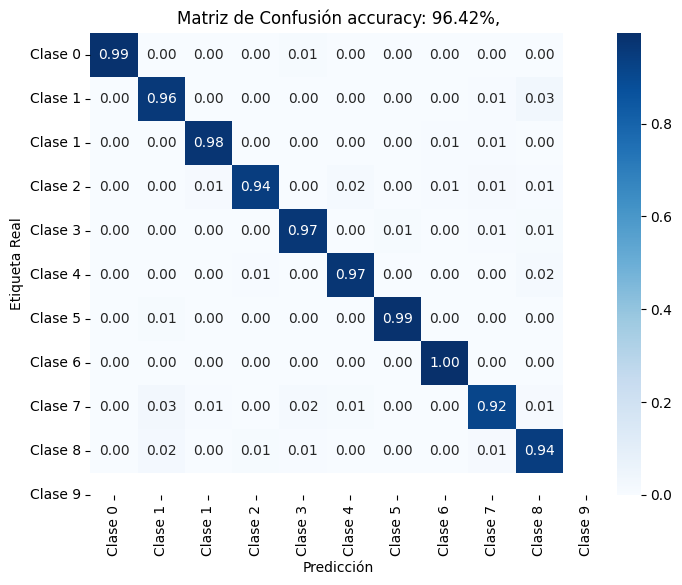

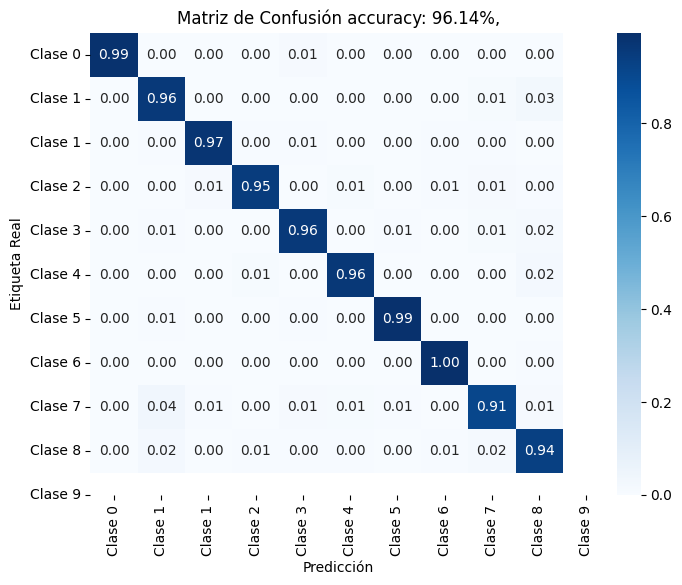

In [22]:
#----------------Matriz de confusión---------------------------
model1.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model1(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model1(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()


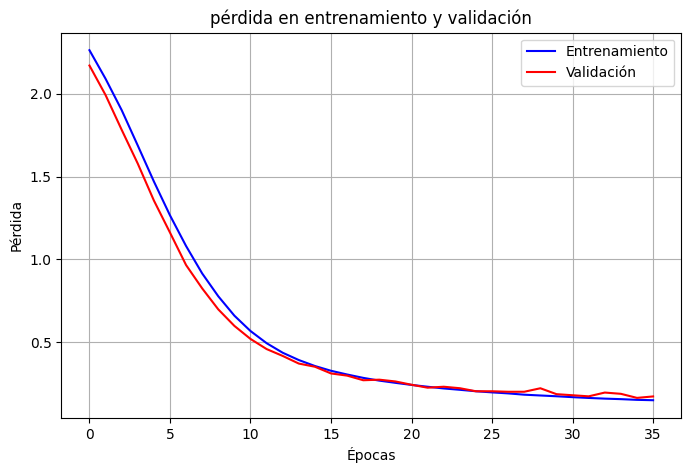

In [21]:
# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.plot(epocas, loss_train, 'b', label = 'Entrenamiento')
plt.plot(epocas, loss_val, 'r', label = 'Validación')
plt.grid()
plt.legend()

**(b) 40 neuronas en la capa oculta y función de activación ReLU, y 1000 épocas como máximo.**

In [23]:
model2 = nn.Sequential(
          nn.Linear(64, 40),
          nn.ReLU(),
          nn.Linear(40,10)
        )

In [24]:
device = torch.device('cuda')

model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [25]:
start = time.time()

loss_train= []
loss_val= []
accuracy_t = [] #guarda accuracy en cada batch, en el entrenamiento
accuracy_v = []
epocas = []
cont = 0
paciencia = 8
truelabels = []
prediclabels = []
# loop over the dataset multiple times
for epoch in range(1000):
  # Guardar loss de cada batch
  loss_train_batches = [] # guarda pérdidas de cada batch en el entrenamiento
  loss_val_batches = []
  model2.train()
  correct = 0
  total = 0
  total1 = 0
  correct1 = 0

  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model2(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de entrenamiento y acurracy en el batch actual
    loss_train_batches.append(loss.item())

##-----------Accuracy en la época actual--------------------------------------
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  accuracy_t.append(accuracy)
  ##-----------------------------------------------------------------------------------------

  # Pérdida de entrenamiento y accuracy en la época actual
  loss_train.append(np.mean(loss_train_batches)) #***loss promedio en cada época***


###--------------------***Predicción en el conjunto de validación***------------------
  model2.eval()
  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model2(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
##-----------Accuracy en la época actual--------------------------------------
      _, predicted = torch.max(outputs, 1)
      total1 += labels.size(0)
      correct1 += (predicted == labels).sum().item()
  accuracy = correct1 / total1
  accuracy_v.append(accuracy)
##-------------------------------------------------------------------------------------------

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epocas.append(epoch)
  if len(loss_val)>1:
    dif=loss_val[-1]-loss_val[-2]
    if dif >= 0:
      cont+=1
      if cont >= paciencia:
        break


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch: %d, mean train loss: %.4f, mean val loss: %.4f, accuracy train: %.4f, accuracy val: %.4f' %((epoch), loss_train[epoch], loss_val[epoch], accuracy_t[epoch], accuracy_v[epoch] ))


# Crea un mapa de calor de la matriz de confusión-------------------------------------------
last.append(accuracy_v[epoch-1])
end = time.time()

print('Finished Training, total time %f seconds' % (end - start))

epoch: 0, mean train loss: 2.1148, mean val loss: 1.8973, accuracy train: 0.3820, accuracy val: 0.6590
epoch: 1, mean train loss: 1.6906, mean val loss: 1.4560, accuracy train: 0.7327, accuracy val: 0.7870
epoch: 2, mean train loss: 1.2554, mean val loss: 1.0459, accuracy train: 0.8120, accuracy val: 0.8414
epoch: 3, mean train loss: 0.8781, mean val loss: 0.7063, accuracy train: 0.8544, accuracy val: 0.8774
epoch: 4, mean train loss: 0.6209, mean val loss: 0.5232, accuracy train: 0.8895, accuracy val: 0.9080
epoch: 5, mean train loss: 0.4641, mean val loss: 0.4239, accuracy train: 0.9145, accuracy val: 0.9180
epoch: 6, mean train loss: 0.3646, mean val loss: 0.3389, accuracy train: 0.9316, accuracy val: 0.9280
epoch: 7, mean train loss: 0.3012, mean val loss: 0.2838, accuracy train: 0.9385, accuracy val: 0.9310
epoch: 8, mean train loss: 0.2567, mean val loss: 0.2498, accuracy train: 0.9461, accuracy val: 0.9379
epoch: 9, mean train loss: 0.2253, mean val loss: 0.2220, accuracy train:

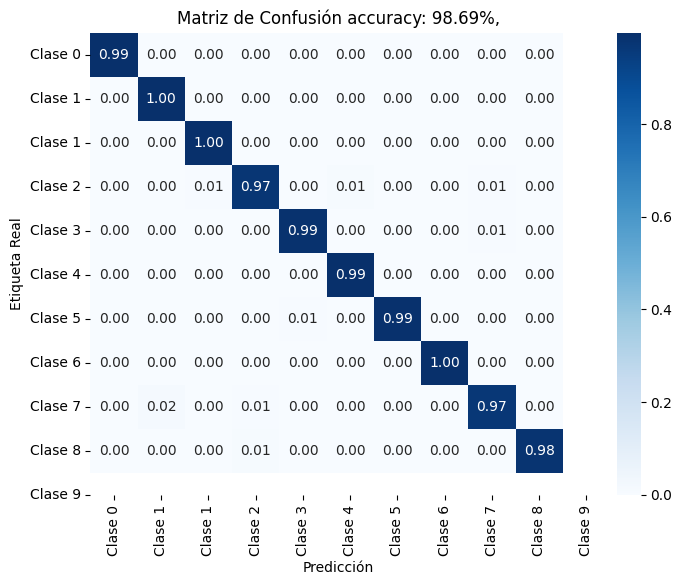

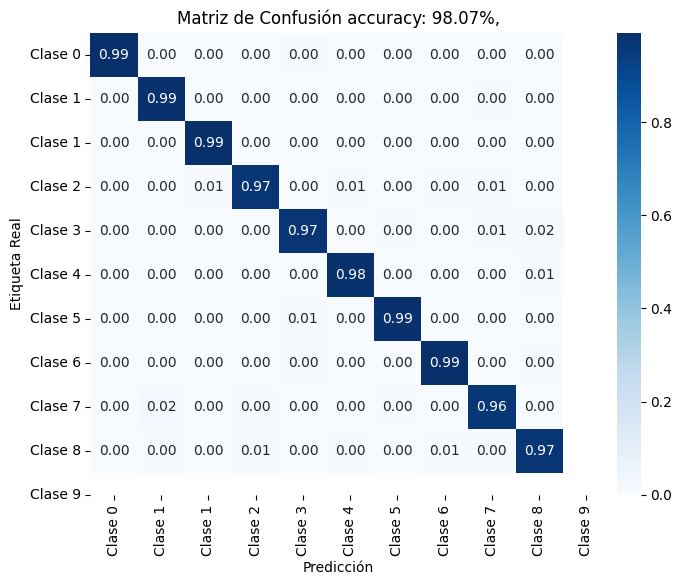

In [26]:
#----------------Matriz de confusión---------------------------
model2.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model2(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model2(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()

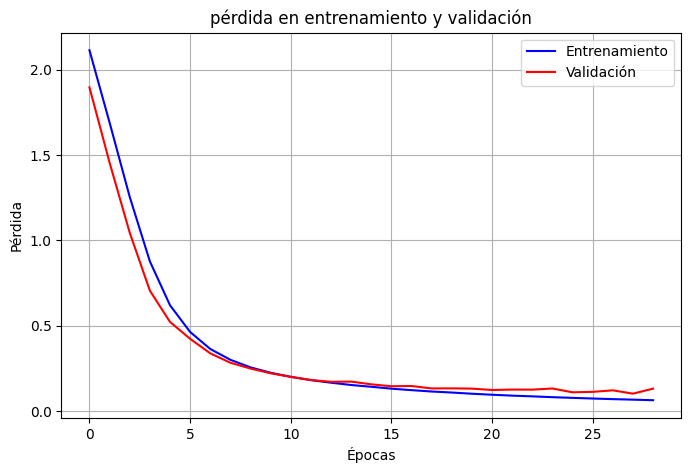

In [27]:
# Graficar loss de entrenamiento Y validación-----------------------------
plt.figure(figsize = (8, 5))
plt.title('pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.plot(epocas, loss_train, 'b', label = 'Entrenamiento')
plt.plot(epocas, loss_val, 'r', label = 'Validación')
plt.grid()
plt.legend()

(c) 10 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo

In [28]:
model3 = nn.Sequential(
          nn.Linear(64, 10),
          nn.Tanh(),
          nn.Linear(10,10)
        )

In [29]:
device = torch.device('cuda')

model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=1e-3)

In [30]:
start = time.time()

loss_train= []
loss_val= []
accuracy_t = [] #guarda accuracy en cada batch, en el entrenamiento
accuracy_v = []
epocas = []
cont = 0
paciencia = 9
truelabels = []
prediclabels = []
# loop over the dataset multiple times
for epoch in range(1000):
  # Guardar loss de cada batch
  loss_train_batches = [] # guarda pérdidas de cada batch en el entrenamiento
  loss_val_batches = []
  model3.train()
  correct = 0
  total = 0
  total1 = 0
  correct1 = 0

  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model3(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de entrenamiento y acurracy en el batch actual
    loss_train_batches.append(loss.item())

##-----------Accuracy en la época actual--------------------------------------
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  accuracy_t.append(accuracy)
  ##-----------------------------------------------------------------------------------------

  # Pérdida de entrenamiento y accuracy en la época actual
  loss_train.append(np.mean(loss_train_batches)) #***loss promedio en cada época***

###--------------------***Predicción en el conjunto de validación***------------------
  model3.eval()


  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model3(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
##-----------Accuracy en la época actual--------------------------------------
      _, predicted = torch.max(outputs, 1)
      total1 += labels.size(0)
      correct1 += (predicted == labels).sum().item()
  accuracy = correct1 / total1
  accuracy_v.append(accuracy)
##-------------------------------------------------------------------------------------------

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epocas.append(epoch)
  if len(loss_val)>1:
    dif=loss_val[-1]-loss_val[-2]
    if dif >= 0:
      cont+=1
      if cont >= paciencia:
        break


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch: %d, mean train loss: %.4f, mean val loss: %.4f, accuracy train: %.4f, accuracy val: %.4f' %((epoch), loss_train[epoch], loss_val[epoch], accuracy_t[epoch], accuracy_v[epoch] ))


# Crea un mapa de calor de la matriz de confusión-------------------------------------------
last.append(accuracy_v[epoch-1])
end = time.time()

print('Finished Training, total time %f seconds' % (end - start))

epoch: 0, mean train loss: 2.2626, mean val loss: 2.1205, accuracy train: 0.1417, accuracy val: 0.2061
epoch: 1, mean train loss: 1.9894, mean val loss: 1.8933, accuracy train: 0.3363, accuracy val: 0.4184
epoch: 2, mean train loss: 1.7755, mean val loss: 1.6945, accuracy train: 0.5178, accuracy val: 0.5579
epoch: 3, mean train loss: 1.5984, mean val loss: 1.5155, accuracy train: 0.6239, accuracy val: 0.6513
epoch: 4, mean train loss: 1.4441, mean val loss: 1.3793, accuracy train: 0.7022, accuracy val: 0.7241
epoch: 5, mean train loss: 1.3061, mean val loss: 1.2423, accuracy train: 0.7630, accuracy val: 0.7762
epoch: 6, mean train loss: 1.1827, mean val loss: 1.1360, accuracy train: 0.8113, accuracy val: 0.8207
epoch: 7, mean train loss: 1.0744, mean val loss: 1.0203, accuracy train: 0.8432, accuracy val: 0.8552
epoch: 8, mean train loss: 0.9786, mean val loss: 0.9393, accuracy train: 0.8682, accuracy val: 0.8828
epoch: 9, mean train loss: 0.8947, mean val loss: 0.8506, accuracy train:

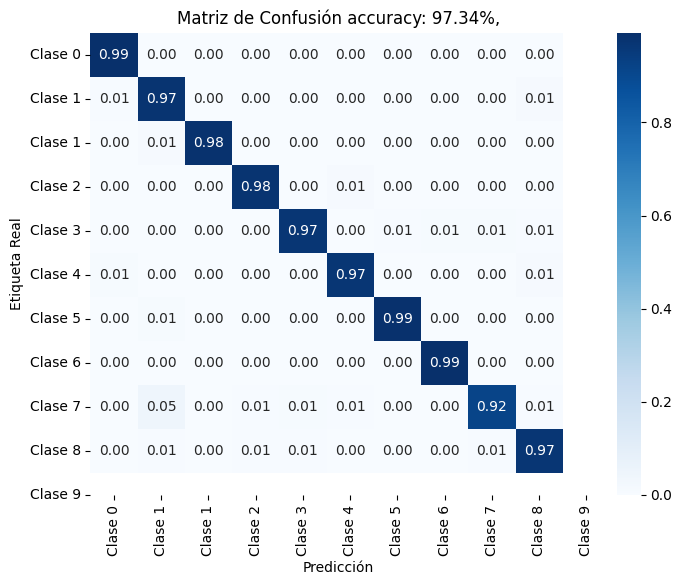

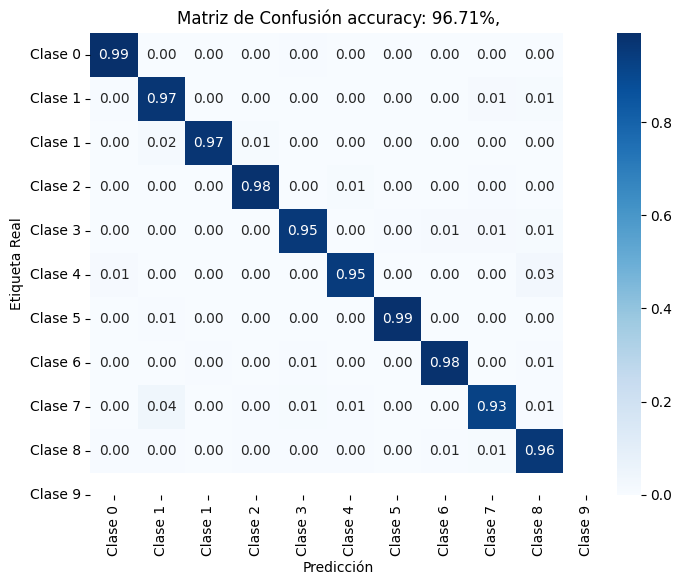

In [31]:
#----------------Matriz de confusión---------------------------
model3.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model3(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model3(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()


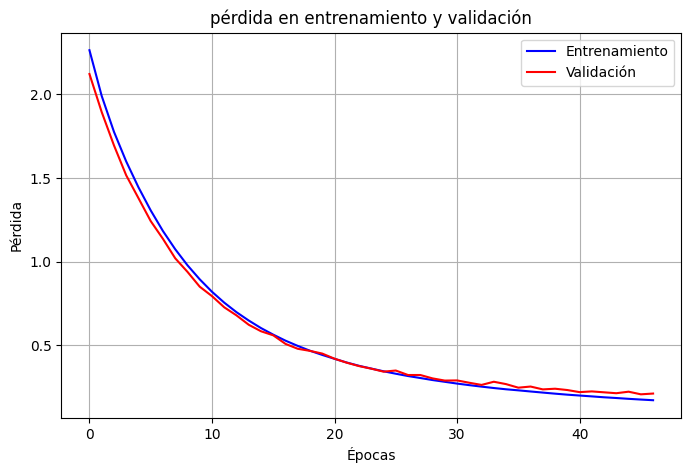

In [32]:
# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.plot(epocas, loss_train, 'b', label = 'Entrenamiento')
plt.plot(epocas, loss_val, 'r', label = 'Validación')
plt.grid()
plt.legend()

(d) 40 neuronas en la capa oculta y función de activación Tanh, y 1000 épocas como máximo.

In [33]:
model4 = nn.Sequential(
          nn.Linear(64, 40),
          nn.Tanh(),
          nn.Linear(40,10)
        )

In [34]:
device = torch.device('cuda')

model4 = model4.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model4.parameters(), lr=1e-3)

In [35]:
start = time.time()

loss_train= []
loss_val= []
accuracy_t = [] #guarda accuracy en cada batch, en el entrenamiento
accuracy_v = []
epocas = []
cont = 0
paciencia =6
truelabels = []
prediclabels = []
# loop over the dataset multiple times
for epoch in range(1000):
  # Guardar loss de cada batch
  loss_train_batches = [] # guarda pérdidas de cada batch en el entrenamiento
  loss_val_batches = []
  model4.train()
  correct = 0
  total = 0
  total1 = 0
  correct1 = 0

  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model4(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de entrenamiento y acurracy en el batch actual
    loss_train_batches.append(loss.item())

##-----------Accuracy en la época actual--------------------------------------
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  accuracy_t.append(accuracy)
  ##-----------------------------------------------------------------------------------------

  # Pérdida de entrenamiento y accuracy en la época actual
  loss_train.append(np.mean(loss_train_batches)) #***loss promedio en cada época***

###--------------------***Predicción en el conjunto de validación***------------------
  model4.eval()


  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model4(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
##-----------Accuracy en la época actual--------------------------------------
      _, predicted = torch.max(outputs, 1)
      total1 += labels.size(0)
      correct1 += (predicted == labels).sum().item()
  accuracy = correct1 / total1
  accuracy_v.append(accuracy)
##-------------------------------------------------------------------------------------------

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epocas.append(epoch)
  if len(loss_val)>1:
    dif=loss_val[-1]-loss_val[-2]
    if dif >= 0:
      cont+=1
      if cont >= paciencia:
        break


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch: %d, mean train loss: %.4f, mean val loss: %.4f, accuracy train: %.4f, accuracy val: %f' %((epoch), loss_train[epoch], loss_val[epoch], accuracy_t[epoch], accuracy_v[epoch] ))


# Crea un mapa de calor de la matriz de confusión-------------------------------------------
last.append(accuracy_v[epoch-1])
end = time.time()

print('Finished Training, total time %f seconds' % (end - start))

epoch: 0, mean train loss: 2.0498, mean val loss: 1.7485, accuracy train: 0.3629, accuracy val: 0.659770
epoch: 1, mean train loss: 1.5351, mean val loss: 1.3248, accuracy train: 0.7235, accuracy val: 0.802299
epoch: 2, mean train loss: 1.1528, mean val loss: 0.9824, accuracy train: 0.8245, accuracy val: 0.856705
epoch: 3, mean train loss: 0.8745, mean val loss: 0.7584, accuracy train: 0.8695, accuracy val: 0.890421
epoch: 4, mean train loss: 0.6741, mean val loss: 0.5969, accuracy train: 0.8991, accuracy val: 0.917241
epoch: 5, mean train loss: 0.5332, mean val loss: 0.4888, accuracy train: 0.9175, accuracy val: 0.927969
epoch: 6, mean train loss: 0.4347, mean val loss: 0.4001, accuracy train: 0.9320, accuracy val: 0.936398
epoch: 7, mean train loss: 0.3660, mean val loss: 0.3456, accuracy train: 0.9398, accuracy val: 0.941762
epoch: 8, mean train loss: 0.3139, mean val loss: 0.3034, accuracy train: 0.9474, accuracy val: 0.943295
epoch: 9, mean train loss: 0.2750, mean val loss: 0.259

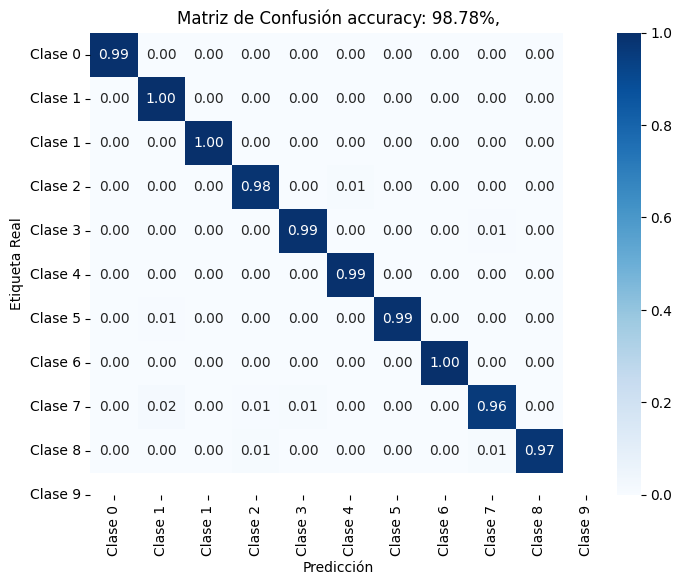

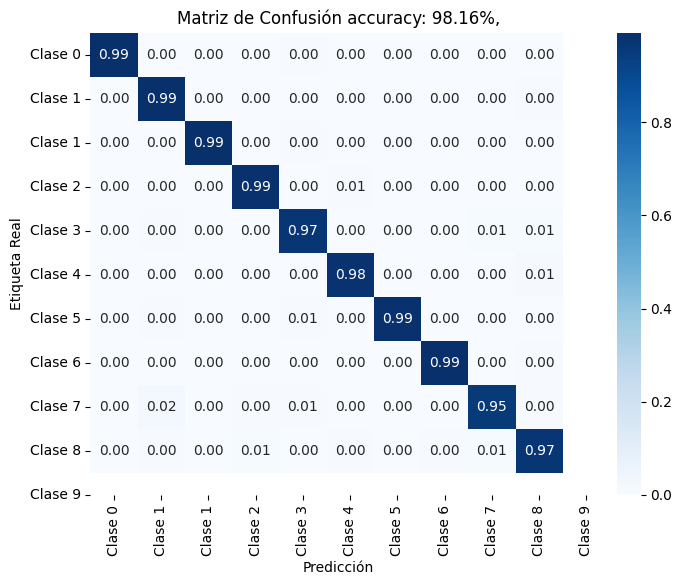

In [36]:
#----------------Matriz de confusión---------------------------
model4.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model4(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model4(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()


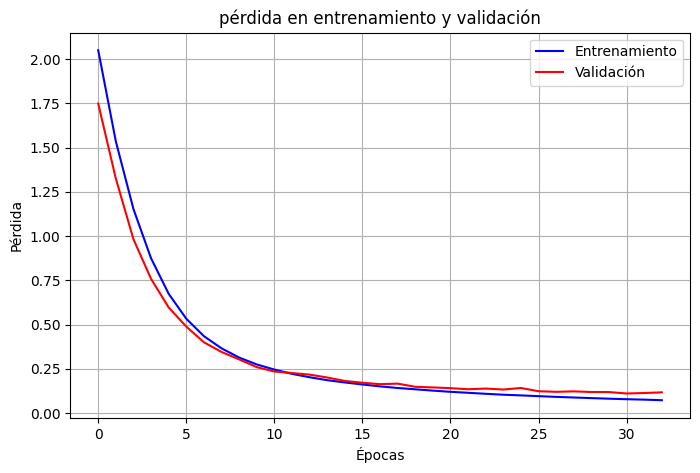

In [37]:
# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.plot(epocas, loss_train, 'b', label = 'Entrenamiento')
plt.plot(epocas, loss_val, 'r', label = 'Validación')
plt.grid()
plt.legend()

(e) 2 capas ocultas con 10 y 10 neuronas cada una y función de activación ReLU, y 1000 épocas
como máximo.

In [38]:
model5 = nn.Sequential(
          nn.Linear(64, 10),
          nn.ReLU(),
          nn.Linear(10,10),
          nn.ReLU(),
          nn.Linear(10,10)
        )

In [39]:
device = torch.device('cuda')

model5 = model5.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model5.parameters(), lr=1e-3)

In [40]:
start = time.time()

loss_train= []
loss_val= []
accuracy_t = [] #guarda accuracy en cada batch, en el entrenamiento
accuracy_v = []
epocas = []
cont = 0
paciencia = 4
truelabels = []
prediclabels = []
# loop over the dataset multiple times
for epoch in range(1000):
  # Guardar loss de cada batch
  loss_train_batches = [] # guarda pérdidas de cada batch en el entrenamiento
  loss_val_batches = []
  model5.train()
  correct = 0
  total = 0
  total1 = 0
  correct1 = 0

  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model5(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de entrenamiento y acurracy en el batch actual
    loss_train_batches.append(loss.item())

##-----------Accuracy en la época actual--------------------------------------
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  accuracy_t.append(accuracy)
  ##-----------------------------------------------------------------------------------------

  # Pérdida de entrenamiento y accuracy en la época actual
  loss_train.append(np.mean(loss_train_batches)) #***loss promedio en cada época***

###--------------------***Predicción en el conjunto de validación***------------------
  model5.eval()


  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model5(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
##-----------Accuracy en la época actual--------------------------------------
      _, predicted = torch.max(outputs, 1)
      total1 += labels.size(0)
      correct1 += (predicted == labels).sum().item()
  accuracy = correct1 / total1
  accuracy_v.append(accuracy)
##-------------------------------------------------------------------------------------------

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epocas.append(epoch)
  if len(loss_val)>1:
    dif=loss_val[-1]-loss_val[-2]
    if dif >= 0:
      cont+=1
      if cont >= paciencia:
        break


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch: %d, mean train loss: %.4f, mean val loss: %.4f, accuracy train: %.4f, accuracy val: %f' %((epoch), loss_train[epoch], loss_val[epoch], accuracy_t[epoch], accuracy_v[epoch] ))


# Crea un mapa de calor de la matriz de confusión-------------------------------------------
last.append(accuracy_v[epoch-1])
end = time.time()

print('Finished Training, total time %f seconds' % (end - start))

epoch: 0, mean train loss: 2.3053, mean val loss: 2.2729, accuracy train: 0.1220, accuracy val: 0.186973
epoch: 1, mean train loss: 2.2395, mean val loss: 2.1855, accuracy train: 0.2022, accuracy val: 0.293487
epoch: 2, mean train loss: 2.1144, mean val loss: 2.0272, accuracy train: 0.3754, accuracy val: 0.470498
epoch: 3, mean train loss: 1.9106, mean val loss: 1.7916, accuracy train: 0.4990, accuracy val: 0.525670
epoch: 4, mean train loss: 1.6609, mean val loss: 1.5432, accuracy train: 0.5582, accuracy val: 0.603065
epoch: 5, mean train loss: 1.4189, mean val loss: 1.3125, accuracy train: 0.6351, accuracy val: 0.667433
epoch: 6, mean train loss: 1.2064, mean val loss: 1.1136, accuracy train: 0.6953, accuracy val: 0.718774
epoch: 7, mean train loss: 1.0337, mean val loss: 0.9642, accuracy train: 0.7176, accuracy val: 0.744061
epoch: 8, mean train loss: 0.8962, mean val loss: 0.8525, accuracy train: 0.7344, accuracy val: 0.755556
epoch: 9, mean train loss: 0.7902, mean val loss: 0.759

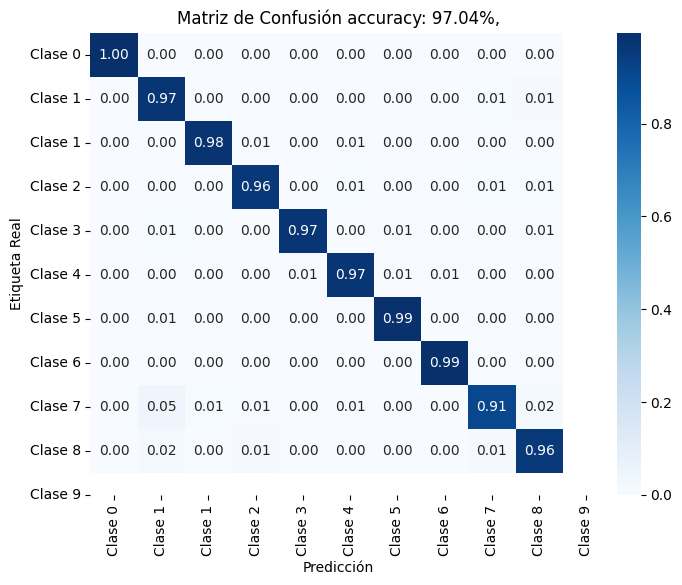

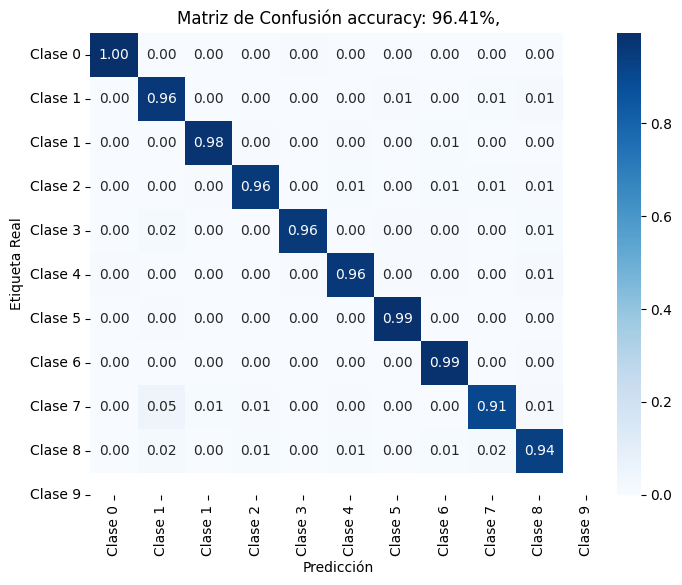

In [41]:
#----------------Matriz de confusión---------------------------
model5.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model5(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model5(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()


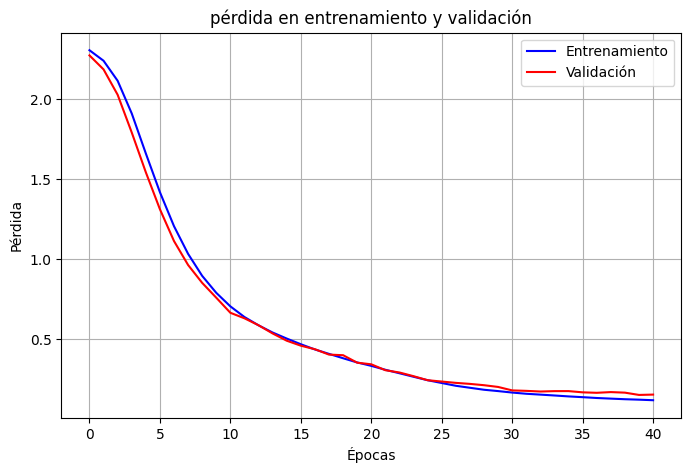

In [42]:
# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.plot(epocas, loss_train, 'b', label = 'Entrenamiento')
plt.plot(epocas, loss_val, 'r', label = 'Validación')
plt.grid()
plt.legend()

(f) 2 capas ocultas con 40 y 40 neuronas cada una y función de activación ReLU, y 1000 épocas
como máximo.

In [27]:
model6 = nn.Sequential(
          nn.Linear(64, 40),
          nn.ReLU(),
          nn.Linear(40,40),
          nn.ReLU(),
          nn.Linear(40,10)
        )

In [28]:
device = torch.device('cuda')

model6 = model6.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model6.parameters(), lr=1e-3)

In [29]:
start = time.time()

loss_train= []
loss_val= []
accuracy_t = [] #guarda accuracy en cada batch, en el entrenamiento
accuracy_v = []
epocas = []
cont = 0
paciencia = 5
truelabels = []
prediclabels = []
# loop over the dataset multiple times
for epoch in range(1000):
  # Guardar loss de cada batch
  loss_train_batches = [] # guarda pérdidas de cada batch en el entrenamiento
  loss_val_batches = []
  model6.train()
  correct = 0
  total = 0
  total1 = 0
  correct1 = 0

  # Train on the current epoch
  for i, data in enumerate(dataloader_train, 0):
    # Process the current batch
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = model6(inputs)
    loss = criterion(outputs, labels)
    loss.backward() # backpropagation
    optimizer.step()

    # Por completar: calcule la pérdida de entrenamiento y acurracy en el batch actual
    loss_train_batches.append(loss.item())

##-----------Accuracy en la época actual--------------------------------------
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
  accuracy = correct / total
  accuracy_t.append(accuracy)
  ##-----------------------------------------------------------------------------------------

  # Pérdida de entrenamiento y accuracy en la época actual
  loss_train.append(np.mean(loss_train_batches)) #***loss promedio en cada época***

###--------------------***Predicción en el conjunto de validación***------------------
  model6.eval()


  with torch.no_grad():
    # Por completar: calcule la pérdida de validación y acurracy en la época actual
    for i, data in enumerate(dataloader_val, 0):
      # Procesar batch actual
      inputs = data["features"].to(device) # Características
      labels = data["labels"].to(device)   # Clases

      outputs = model6(inputs)              # Obtenemos predicciones

      # Guardamos la pérdida de validación en el batch actual
      loss = criterion(outputs, labels)
      loss_val_batches.append(loss.item())
##-----------Accuracy en la época actual--------------------------------------
      _, predicted = torch.max(outputs, 1)
      total1 += labels.size(0)
      correct1 += (predicted == labels).sum().item()
  accuracy = correct1 / total1
  accuracy_v.append(accuracy)
##-------------------------------------------------------------------------------------------

  # Guardamos el Loss de validación de la época actual
  loss_val.append(np.mean(loss_val_batches)) # Loss promedio de los batches
  epocas.append(epoch)
  if len(loss_val)>1:
    dif=loss_val[-1]-loss_val[-2]
    if dif >= 0:
      cont+=1
      if cont >= paciencia:
        break


  # Por hacer: imprima la pérdida de entrenamiento/validación y acurracy en la época actual
  print('epoch: %d, mean train loss: %.4f, mean val loss: %.4f, accuracy train: %.4f, accuracy val: %f' %((epoch), loss_train[epoch], loss_val[epoch], accuracy_t[epoch], accuracy_v[epoch] ))


# Crea un mapa de calor de la matriz de confusión-------------------------------------------
last.append(accuracy_v[epoch-1])
end = time.time()

print('Finished Training, total time %f seconds' % (end - start))

epoch: 0, mean train loss: 2.1975, mean val loss: 2.0518, accuracy train: 0.3205, accuracy val: 0.472031
epoch: 1, mean train loss: 1.8650, mean val loss: 1.5862, accuracy train: 0.5358, accuracy val: 0.681226
epoch: 2, mean train loss: 1.2899, mean val loss: 0.9251, accuracy train: 0.7679, accuracy val: 0.868199
epoch: 3, mean train loss: 0.6830, mean val loss: 0.4418, accuracy train: 0.8912, accuracy val: 0.924138
epoch: 4, mean train loss: 0.3613, mean val loss: 0.2857, accuracy train: 0.9231, accuracy val: 0.940996
epoch: 5, mean train loss: 0.2472, mean val loss: 0.2218, accuracy train: 0.9379, accuracy val: 0.944828
epoch: 6, mean train loss: 0.1946, mean val loss: 0.1802, accuracy train: 0.9507, accuracy val: 0.948659
epoch: 7, mean train loss: 0.1644, mean val loss: 0.1644, accuracy train: 0.9602, accuracy val: 0.952490
epoch: 8, mean train loss: 0.1417, mean val loss: 0.1439, accuracy train: 0.9642, accuracy val: 0.956322
epoch: 9, mean train loss: 0.1241, mean val loss: 0.133

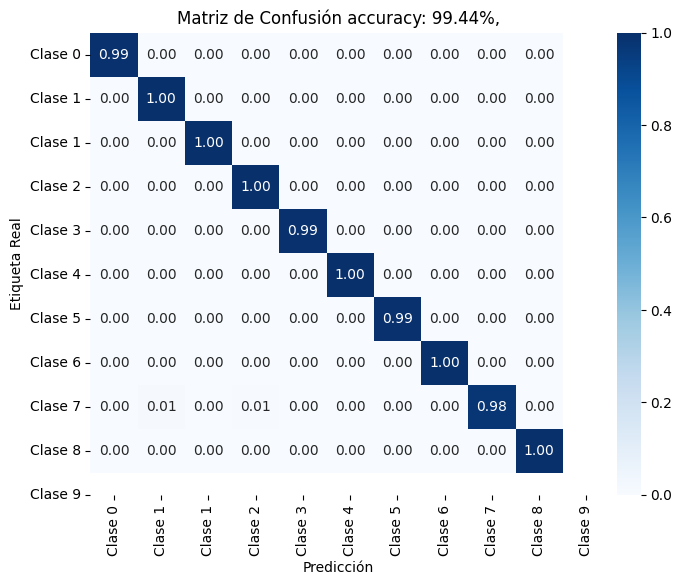

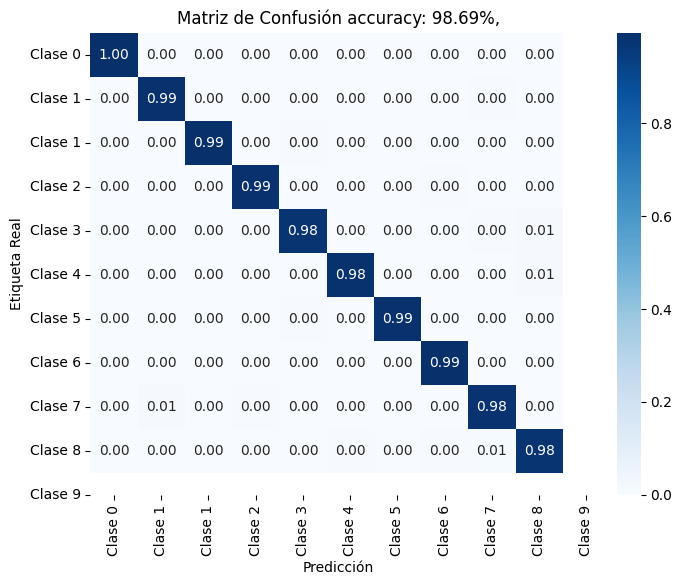

In [30]:
#----------------Matriz de confusión---------------------------
model6.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_train, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model6(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model6(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()


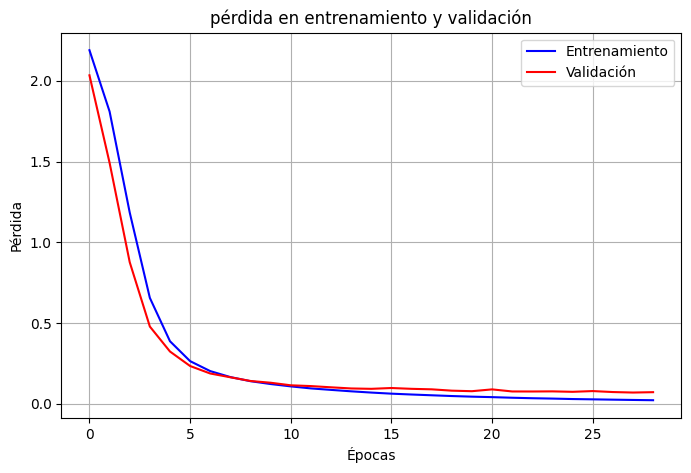

In [47]:
# Graficar loss de entrenamiento Y validación
plt.figure(figsize = (8, 5))
plt.title('pérdida en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.plot(epocas, loss_train, 'b', label = 'Entrenamiento')
plt.plot(epocas, loss_val, 'r', label = 'Validación')
plt.grid()
plt.legend()

**3**) Usando la mejor red encontrada en validación (aquella con mayor accuracy en validación), calcular
la matriz de confusión normalizada y el accuracy normalizado, usando el conjunto de prueba.


In [48]:
modelos = [model1,model2,model3,model4,model5,model6]

max=max(last) #máximo accuracy final
last.index(max) #posición del máximo accuracy

5

In [49]:
model=modelos[last.index(max)]

In [50]:
device = torch.device('cuda')

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(last)

[0.9555555555555556, 0.9662835249042145, 0.9532567049808429, 0.9685823754789272, 0.9478927203065134, 0.9739463601532568]


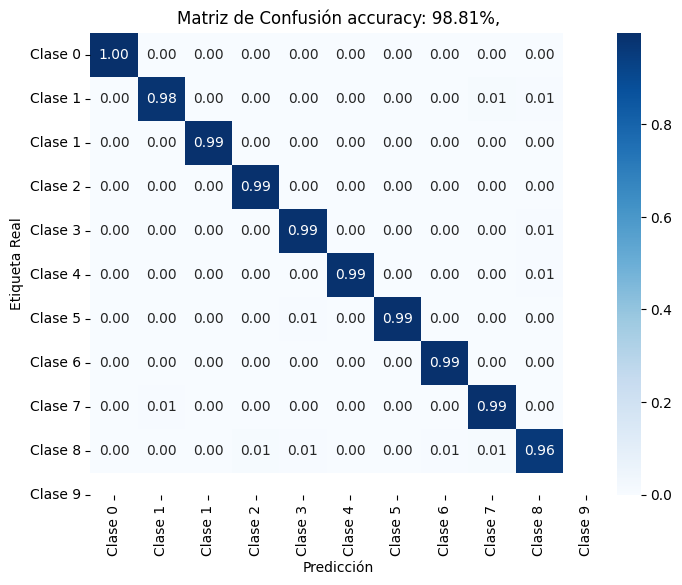

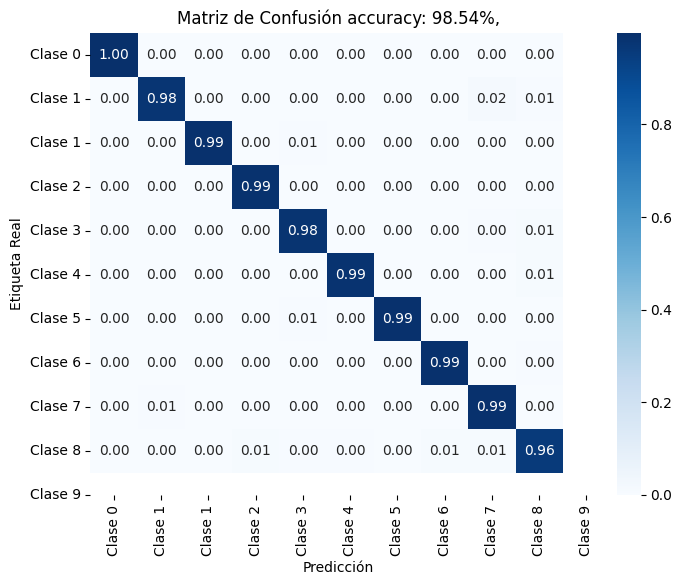

In [51]:
#----------------Matriz de confusión---------------------------
model.eval()
with torch.no_grad():
  for i, data in enumerate(dataloader_test, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
with torch.no_grad():
  for i, data in enumerate(dataloader_val, 0):
    inputs = data["features"].to(device)
    labels = data["labels"].to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    truelabels.extend(labels.cpu().numpy())
    prediclabels.extend(predicted.cpu().numpy())
cm = confusion_matrix(truelabels, prediclabels, normalize='true')
accuracy=accuracy_score(truelabels, prediclabels)
class_labels = ["Clase 0", "Clase 1", "Clase 1", "Clase 2", "Clase 3", "Clase 4", "Clase 5", "Clase 6", "Clase 7", "Clase 8", "Clase 9"]
plt.figure(figsize=(8, 6))
accutxt=f'accuracy: {accuracy*100:.2f}%,'
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión '+ accutxt)
plt.show()
